In [1]:
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
sim.ResetKernel()

# sim_len = 6000

Nlandmarks = 5
N_view = 50

# srt_tm = 2000.
# stp_tm = 8000.

In [2]:
def plotSpks(ax,t,s): # define function to plot spikes in a common way
    ax.plot(t,s,'.')
    ax.set_ylabel('Neuron')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim([0,sim_len])

In [3]:
sim.SetDefaults("stdp_synapse",{"tau_plus": 20.0})
syn_dict = {"model": "stdp_synapse", "alpha": 0.5,"weight": 10.,'Wmax':200.,'delay': 1.,'lambda':10.}

In [4]:
#make sinusoid of HD activity
diam = 4
sin = ((np.sin(np.arange(np.pi*800)/100)+1)*20)//1
orig_sin = sin
for i in range(10):
    sin = np.append(sin,orig_sin)
time = np.arange(1,len(sin)+1)*20.
orig_sin = sin
orig_time = time

m = np.ceil(np.max(orig_time)/500)*500
temp = []
temptime=[]
for i in range(diam):
    temp = np.append(temp,sin+i)
    temptime = np.append(temptime,time)
sin = np.append(sin,temp)
time = np.append(time,temptime)

N = int(np.max(sin))

sim_len = m*2

In [5]:
HD = sim.Create("iaf_psc_alpha",N)
g1 = sim.Create("iaf_psc_alpha",N)
view = sim.Create("iaf_psc_alpha",N_view, params={"tau_minus": 20.0})


In [6]:
params=[]
for i in range(N):
    idx = np.where(sin == i)
    spktms = time[idx]
    params.append({'spike_times':np.sort(spktms)})
    
HD_spikes = sim.Create('spike_generator', N, params)
sim.Connect(HD_spikes,HD,'one_to_one',syn_spec={'weight': 500, 'delay': 0.1})

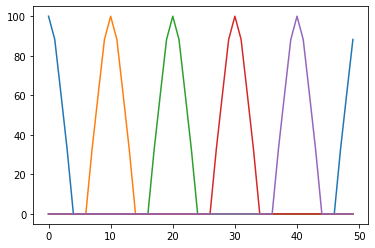

In [7]:
rad = N_view/Nlandmarks
sigma = 2#rad//2
d = np.arange(N_view)
rates = []
for L in np.arange(Nlandmarks):
    bump_center = L*rad
    dis = np.array([min(abs(D-bump_center),abs(D-bump_center-N_view)) for D in d])
    gauss = np.exp(-(dis)**2/2/sigma**2)
    # to spike rate (hz)
    rate =gauss*100
    rate[rate<25]=0
    plt.plot(rate)
    rates.append(np.array(rate))

In [8]:
bump_rad = 2
rad = N/Nlandmarks
landmarkHDs = np.arange(0,N,rad)
landmarkHDs = landmarkHDs.astype(int)
ratetimes = [[] for i in range(N_view)]
spikerates = [[] for i in range(N_view)]

# select evenly distributed landmark cells
# landmarkHDs = np.around(np.arange(0,2*np.pi,(2*np.pi)/Nlandmarks) * N/(2*np.pi)).astype(int)
# landmarkHDs=landmarkHDs[1:]
print(f'Landmarks cells: {landmarkHDs}')
all_times = np.array([])
for idx,landmark in enumerate(landmarkHDs):
    landmarktimes = np.array([])
    for l in range(-bump_rad,bump_rad+1):
        lm = landmark + l
        if lm > N:
            lm = lm - N
        elif lm < 0:
            lm = lm + N
        result = np.where(sin == lm)
        for r in result[0]:
            if time[r] != 0:
                landmarktimes = np.append(landmarktimes, time[r])
    for i,rate in enumerate(rates[idx]):
        ratetimes[i].extend(landmarktimes)
        spikerates[i].extend(np.ones(len(landmarktimes))*rate)
    all_times = np.append(all_times,landmarktimes)

all_times = np.sort(np.unique(all_times))

params2 = []
for i in range(N_view):
    rts = np.array(ratetimes[i])
    srat = np.array(spikerates[i])
    
    idx = np.argsort(rts)
    
    rts = rts[idx]
    srat = srat[idx]
    
    rts, idx = np.unique(rts,return_index=True)
    srat = srat[idx]
    
#     plt.figure()
#     plt.plot(rts,srat)
#     plt.ylim([0,210])
    
    rts = np.append(rts,rts+19)
    srat = np.append(srat,srat*0)
    
    idx = np.argsort(rts)
    
    rts = rts[idx]
    srat = srat[idx]
    
    rts = np.append(rts,rts+max(rts)+1000)
    srat = np.append(srat,srat)

    params2.append({'rate_times':rts, 'rate_values':srat})
    
view_spikes = sim.Create('inhomogeneous_poisson_generator', N_view, params2)
sim.Connect(view_spikes,view,'one_to_one',syn_spec={'weight': 300, 'delay': 0.1})

Landmarks cells: [ 0  8 16 25 33]


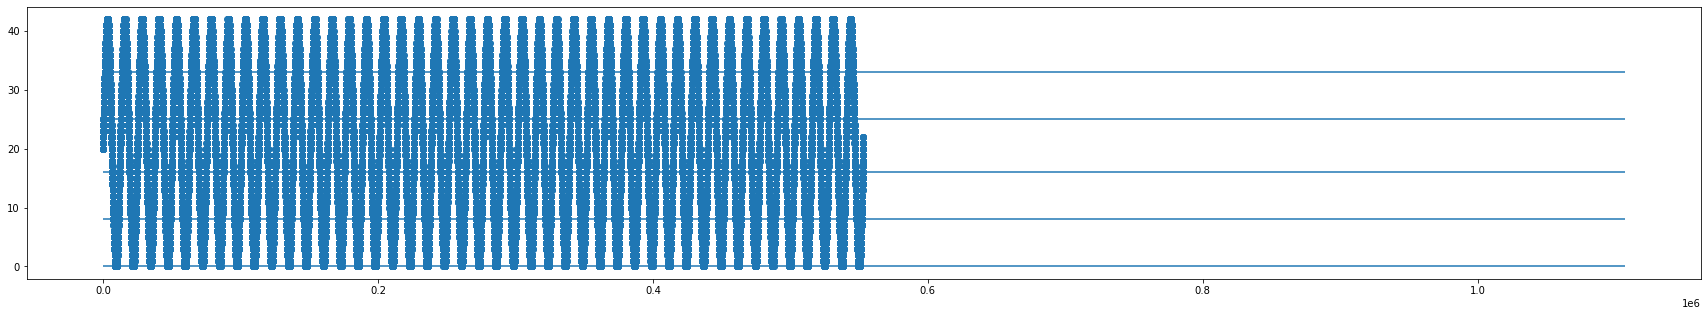

In [9]:
plt.figure(figsize=(30, 5))
plt.scatter(time,sin)
plt.hlines(landmarkHDs,0,sim_len)

In [10]:
# sim.Connect(HD,g1, "one_to_one", syn_spec={'weight': 500, 'delay': 0.1})
sim.Connect(view,HD, "all_to_all", syn_dict)

In [11]:
HD_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})
view_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})

sim.Connect(HD,HD_spikes)
sim.Connect(view,view_spikes)


In [12]:
sim.Simulate(sim_len)

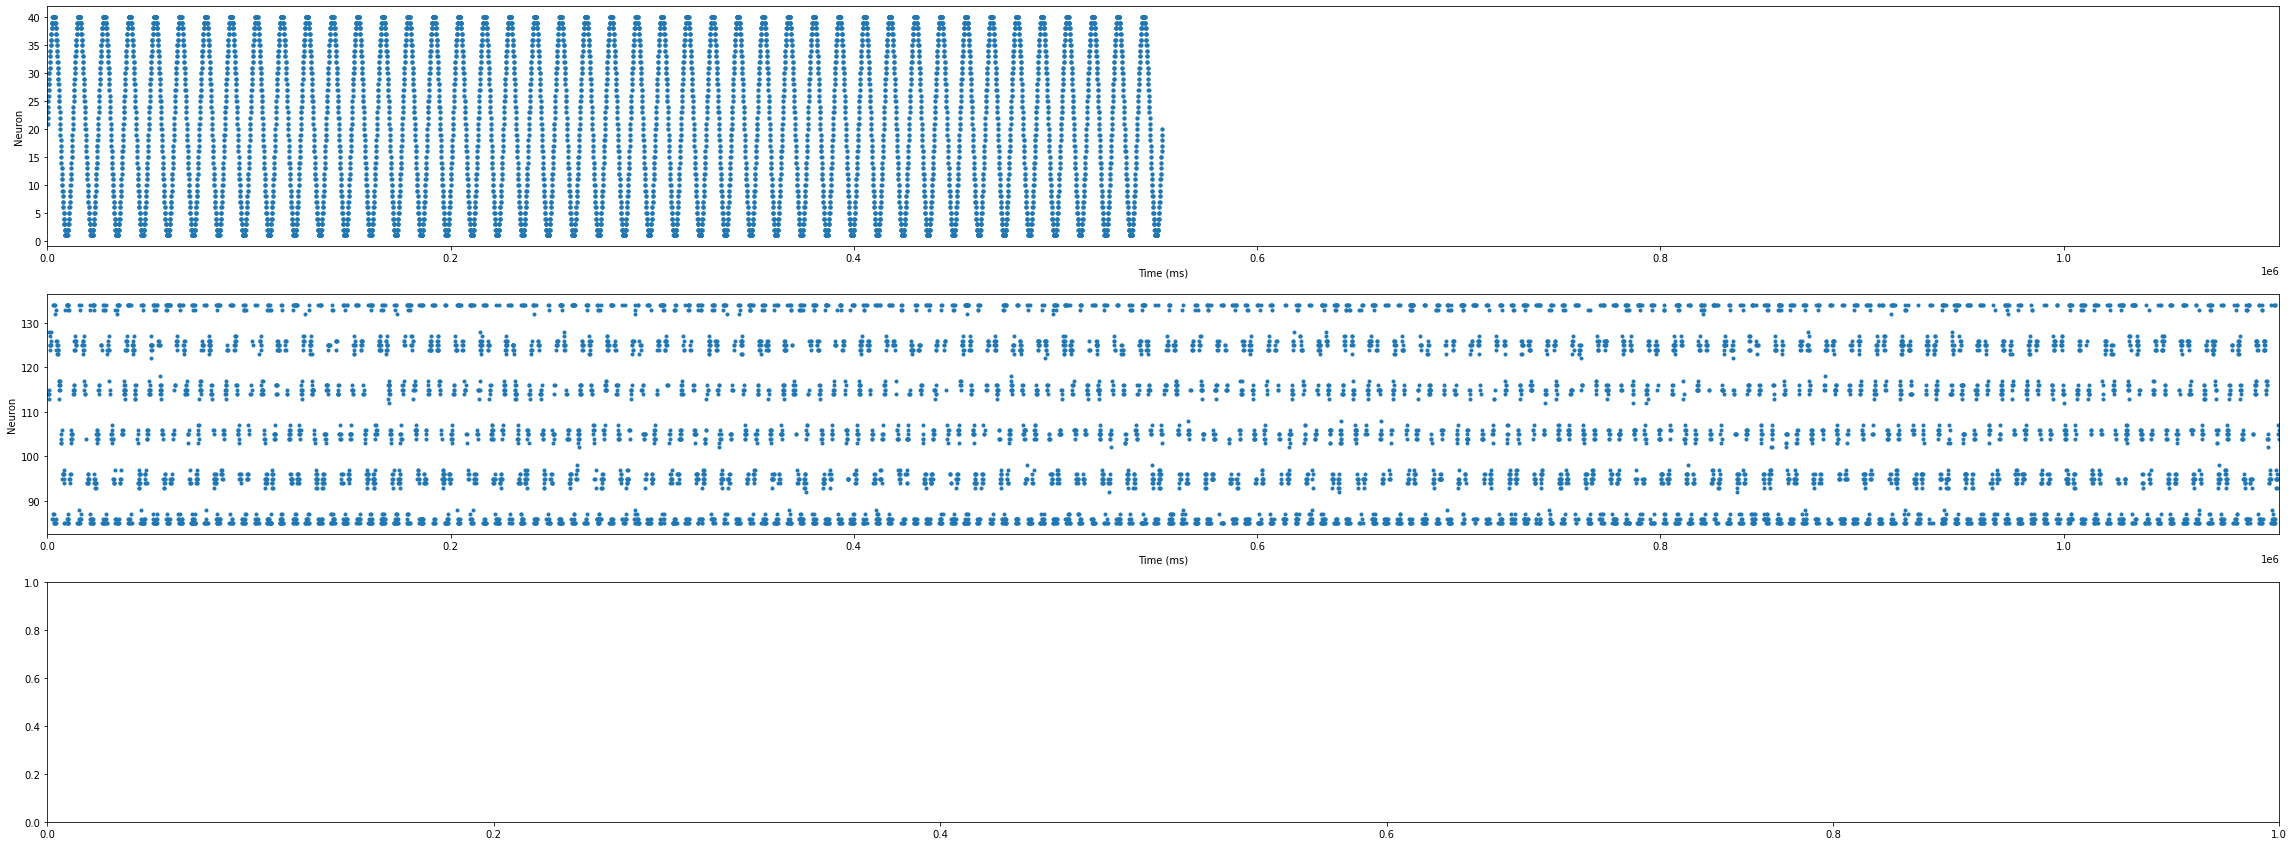

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(40, 15),facecolor='w')

ev = sim.GetStatus(HD_spikes)[0]['events']
t = ev['times']
sp = ev['senders']
plotSpks(ax1,t,sp)

ev = sim.GetStatus(view_spikes)[0]['events']
t = ev['times']
sp = ev['senders']
plotSpks(ax2,t,sp)